# Suitability Analysis: Best place within the Boston Region for a Tufts UEP student and BU Law student to live without a car 
UEP-239 Final Project\
By: Justina Cheng

[DESCRIPTION]

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## Create and View Base Map of Boston Region Zip Code Tabulation Areas (ZCTAs)
To create a GeoDataFrame of the Boston Region ZCTAs, the following steps were used:
1. Massachusetts outline with detailed coastline was imported from MassGIS as a GeoDataFrame.
1. Massachusetts ZCTAs were imported from the Census Bureau as a GeoDataFrame.
1. The outline and ZCTAs GeoDataFrames were converted to the coordinate reference system (CRS) for the Massachusetts Mainland EPSG 6491.
1. Boundaries for the Boston Region Metropolitan Planning Organization (MPO) were imported from MassDOT as a GeoDataFrame, and the CRS was converted to EPSG 6491.
1. The Boston Region was extracted from the MPO.
1. Massachusetts ZCTAs within the Boston Region were extracted using the centroid of the ZCTAs.
1. Massachusetts Surface Water data was imported from MassGIS as a GeoDataFrame, then converted to EPSG 6491 and clipped to the extent of Boston ZCTAs. 

In [2]:
# Import outline of detailed Massachusetts coastline.
outline_25k = gpd.read_file("./data/outline25k/OUTLINE25K_POLY.shp")
outline_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA_ACRES  918 non-null    float64 
 1   OBJECTID    918 non-null    int64   
 2   SHAPE_AREA  918 non-null    float64 
 3   SHAPE_LEN   918 non-null    float64 
 4   geometry    918 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 36.0 KB


epsg:26986


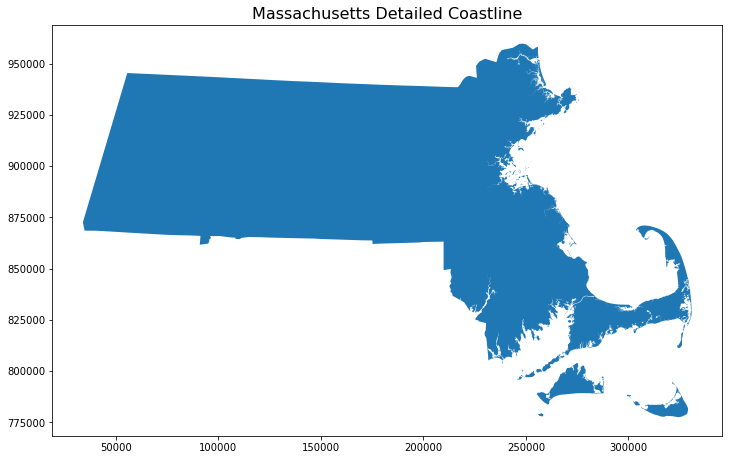

In [3]:
# View CRS and plot.
print(outline_25k.crs)
outline_25k.plot(figsize=(12,12))
plt.title('Massachusetts Detailed Coastline', fontsize=16)
plt.show()

In [4]:
# Import Zip Code Tabulation Areas within Massachusetts.
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 47.1+ KB


epsg:4269


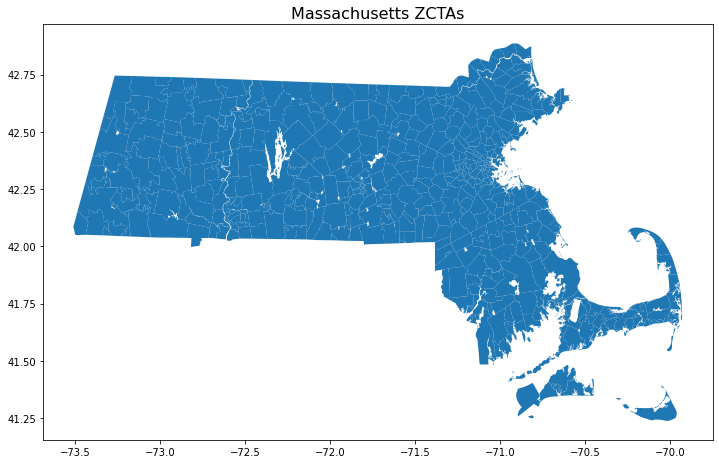

In [5]:
# View CRS and plot.
print(ma_zcta.crs)
ma_zcta.plot(figsize=(12,12))
plt.title('Massachusetts ZCTAs', fontsize=16)
plt.show()

In [6]:
# Convert CRS to Massachusetts Mainland EPSG 6491.
outline_25k = outline_25k.to_crs('epsg:6491')
ma_zcta = ma_zcta.to_crs('epsg:6491')
# Confirm CRSs match.
outline_25k.crs == ma_zcta.crs

True

In [7]:
# Clip ZCTA GDF to 25k MA outline.
ma_zcta_25k = gpd.clip(ma_zcta, outline_25k)
ma_zcta_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 50.9+ KB


In [8]:
# Import boundaries for Boston Region Metropolitan Planning Organization.
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    13 non-null     int64   
 1   MPO         13 non-null     object  
 2   created_us  0 non-null      object  
 3   created_da  13 non-null     object  
 4   last_edite  2 non-null      object  
 5   last_edi_1  13 non-null     object  
 6   GlobalID    13 non-null     object  
 7   ShapeSTAre  13 non-null     float64 
 8   ShapeSTLen  13 non-null     float64 
 9   geometry    13 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.1+ KB


In [9]:
# View MPO dataset.
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


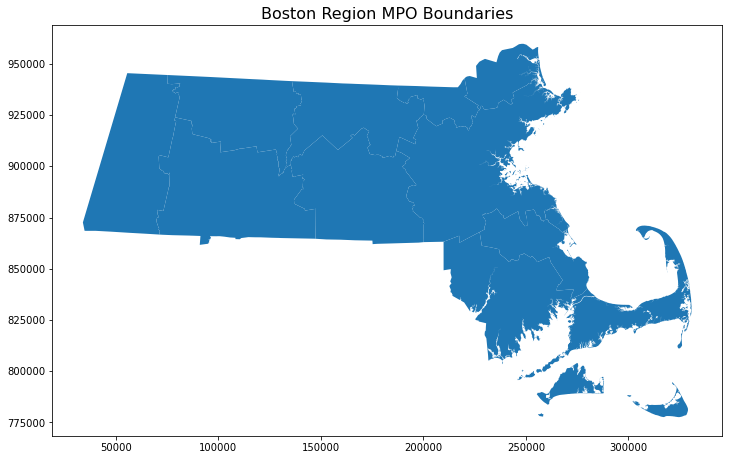

In [10]:
# Convert MPO CRS to EPSG 6491 and plot.
mpo = mpo.to_crs('epsg:6491')
mpo.plot(figsize=(12,12))
plt.title('Boston Region MPO Boundaries', fontsize=16)
plt.show()

In [11]:
# Extract only Boston Region.
boston_region = mpo.loc[mpo.MPO == 'Boston Region'].reset_index()
boston_region

,index,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


In [12]:
# Extract ZCTAs within the Boston Region using the centroid of the ZCTAs.
boston_zcta = ma_zcta_25k[ma_zcta_25k.centroid.within(boston_region.geometry[0])].reset_index()
boston_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       159 non-null    int64   
 1   STATEFP00   159 non-null    object  
 2   ZCTA5CE00   159 non-null    object  
 3   GEOID00     159 non-null    object  
 4   CLASSFP00   159 non-null    object  
 5   MTFCC00     159 non-null    object  
 6   FUNCSTAT00  159 non-null    object  
 7   ALAND00     159 non-null    int64   
 8   AWATER00    159 non-null    int64   
 9   INTPTLAT00  159 non-null    object  
 10  INTPTLON00  159 non-null    object  
 11  PARTFLG00   159 non-null    object  
 12  geometry    159 non-null    geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 16.3+ KB


In [13]:
# View the Boston Region ZCTAs.
boston_zcta

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
1,32,25,01867,2501867,B5,G6350,S,25857991,46300,+42.5351829,-071.1054234,N,"POLYGON ((234193.323 919471.462, 234167.381 91..."
2,33,25,01880,2501880,B5,G6350,S,18969895,1554312,+42.5043600,-071.0640609,N,"POLYGON ((233593.527 918646.107, 233786.679 91..."
3,34,25,01730,2501730,B5,G6350,S,34703585,424511,+42.4993313,-071.2819054,N,"POLYGON ((215991.167 913794.709, 215916.137 91..."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,489,25,02030,2502030,B5,G6350,S,39440450,832120,+42.2341291,-071.2834628,N,"POLYGON ((215268.989 884982.344, 215020.550 88..."
155,490,25,02052,2502052,B5,G6350,S,37335006,608718,+42.1845991,-071.3053065,N,"POLYGON ((214616.455 880362.751, 214622.559 88..."
156,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90..."
157,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89..."


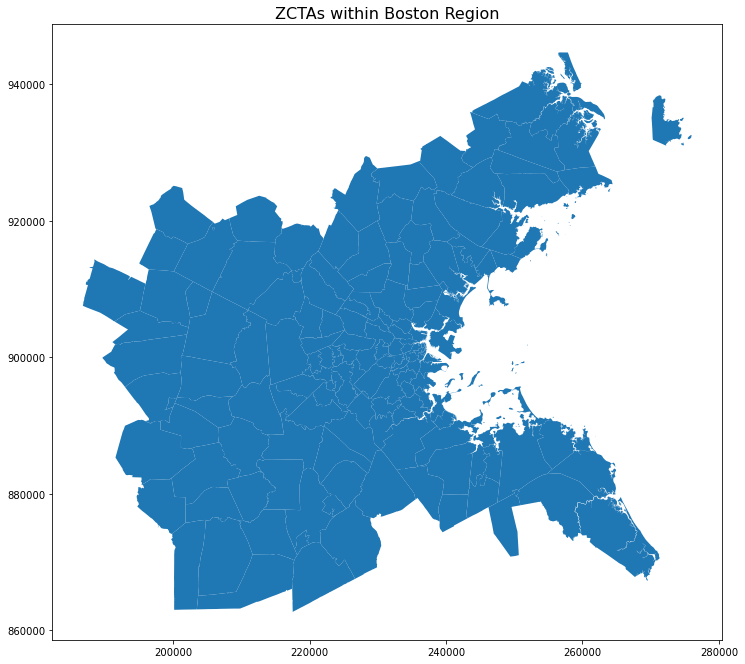

In [14]:
# Plot the Boston Region ZCTAs.
boston_zcta.plot(figsize=(12,12))
plt.title('ZCTAs within Boston Region', fontsize=16)
plt.show()

In [15]:
# Import Massachusetts surface water.
ma_water = gpd.read_file('./data/hydro25k/HYDRO25K_POLY.shp')
print(ma_water.crs)
ma_water.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 71540 entries, 0 to 71539
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MINOR_TOT   71540 non-null  object  
 1   POLY_CODE   71540 non-null  int64   
 2   PWSID       313 non-null    object  
 3   PALIS_ID    71540 non-null  int64   
 4   SOURCE      71540 non-null  object  
 5   MINOR_NUM   71540 non-null  float64 
 6   RESOLUTION  71540 non-null  object  
 7   NAME        4018 non-null   object  
 8   JOIN_ID     71540 non-null  int64   
 9   COASTAL     71540 non-null  int64   
 10  SHAPE_AREA  71540 non-null  float64 
 11  SHAPE_LEN   71540 non-null  float64 
 12  geometry    71538 non-null  geometry
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 7.1+ MB


In [16]:
# Convert MA surface water to same CRS as boston_zcta
ma_water = ma_water.to_crs(boston_zcta.crs)

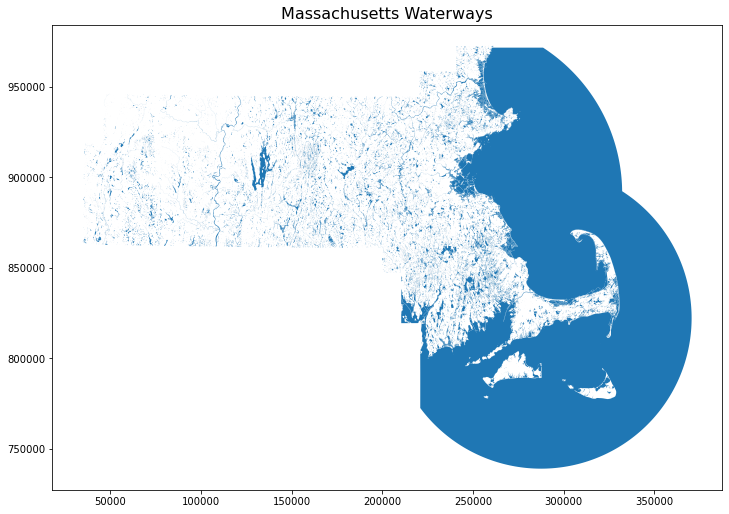

In [17]:
# Plot Massachusetts surface water shapefile.
ma_water.plot(figsize=(12,12))
plt.title('Massachusetts Waterways', fontsize=16)
plt.show()

In [18]:
# Clip MA surface water to the extent of Boston ZCTAs.
boston_water = gpd.clip(ma_water, boston_zcta)

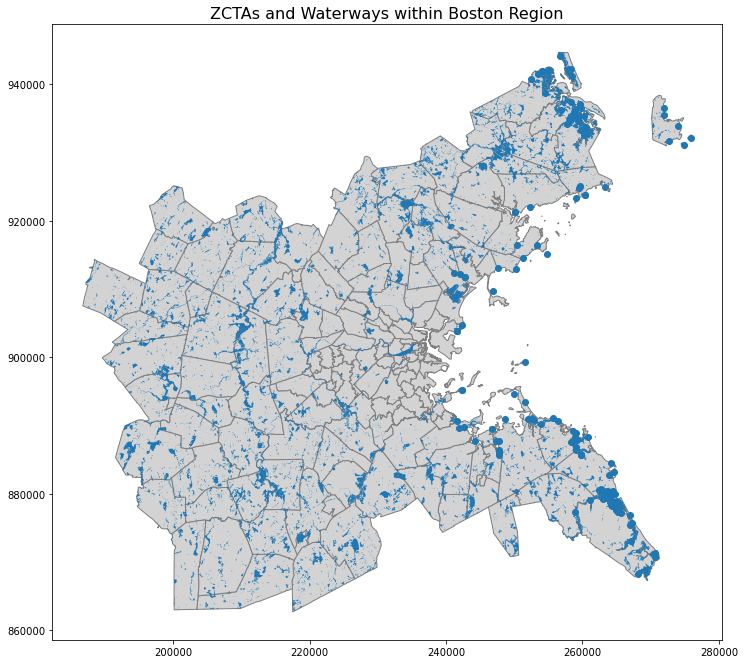

In [19]:
# Plot the Boston Region ZCTAs with surface water.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
plt.title('ZCTAs and Waterways within Boston Region', fontsize=16)
plt.show()

## Find Tufts University and Boston University Locations
To find the locations of Tufts University and Boston University, the Massachusetts Colleges and Universities shapefile was imported from MassGIS as a GeoDataFrame, converted to EPSG 6491, and clipped to the extent of boston_zcta. Tufts University and Boston University were then extracted into a GeoDataGrame

In [20]:
colleges = gpd.read_file('./data/colleges/COLLEGES_PT.shp')
print(colleges.crs)
colleges.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COLLEGE     245 non-null    object  
 1   CAMPUS      99 non-null     object  
 2   ADDRESS     245 non-null    object  
 3   CITY        245 non-null    object  
 4   ZIPCODE     245 non-null    object  
 5   PLUS_FOUR   50 non-null     object  
 6   GEOG_TOWN   245 non-null    object  
 7   MAIN_TEL    245 non-null    object  
 8   URL         245 non-null    object  
 9   NCES_ID     221 non-null    object  
 10  TYPE        245 non-null    object  
 11  NCES_TYPE   245 non-null    object  
 12  CATEGORY    245 non-null    object  
 13  DEGREEOFFR  245 non-null    object  
 14  AWARDSOFFR  245 non-null    object  
 15  LARGEPROG   140 non-null    object  
 16  CAMPUSSETT  245 non-null    object  
 17  CAMPUSHOUS  245 non-null    object  
 18  L_SRC       245 non-null    obj

In [21]:
colleges = colleges.to_crs(boston_zcta.crs)
boston_colleges = gpd.clip(colleges, boston_zcta).reset_index()
boston_colleges

,index,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,...,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
0,21,Dean College,None,99 Main Street,Franklin,02038,None,FRANKLIN,(877) 879-3326,http://www.dean.edu,...,PRI,"4-year, primarily associate's, Private not-for...",Liberal Arts College,"C, A, B",Less than one year certificate;Associate's deg...,None,Suburb: Large,Yes,nces.ed.gov,POINT (208448.992 870587.182)
1,30,Mafy's Nails Academy,None,59 Plymouth Street,Holbrook,02343,None,HOLBROOK,(781)767-1111,http://mafysnailsacademy.com/,...,PRI,"< 2-year, Private for-profit",Private Vocational School,C,Less than one year certificate;One but less th...,Cosmetology,Town: Fringe,No,mass.gov,POINT (240787.796 878343.750)
2,33,Tri County Regional Vocational Technical High ...,None,147 Pond Street,Franklin,02038,None,FRANKLIN,(508) 528-5400,http://www.tri-county.us/adulted,...,PUB,"< 2-year, Public",Adult Education,C,One but less than two years certificate,"Practical Nursing, Vocational Nursing and Nurs...",Suburb: Large,No,nces.ed.gov,POINT (206494.701 871625.006)
3,50,Toni & Guy Hairdressing Academy,Braintree,727A Granite Street,Braintree,02184,None,BRAINTREE,(781) 428-3099,https://braintree.toniguy.edu/,...,PRI,"< 2-year, Private for-profit",Private Vocational School,C,Less than one year certificate;One but less th...,Cosmetology,Suburb: Midsize,No,mass.gov,POINT (239308.942 884212.700)
4,51,Universal Technical Institute of Massachusetts...,None,1 Upland Road,Norwood,02062,None,NORWOOD,(781) 948-2000,https://www.uti.edu/,...,PRI,"2-year, Private for-profit",Technical Institute,C,Two but less than 4 years certificate,Automobile/Automotive Mechanics Technology/Tec...,Suburb: Large,No,nces.ed.gov,POINT (224577.545 884401.436)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,239,Flavia Leal Institute of Aesthetics and Nail A...,Woburn,"600 West Cummings Park, Suite 1000",Woburn,01801,None,WOBURN,(617) 389-9723,http://www.flavialealinstitute.com/,...,PRI,"< 2-year, Private for-profit",Private Vocational School,C,Less than one year certificate;One but less th...,Cosmetology,Suburb: Large,No,mass.gov,POINT (230629.012 916196.130)
131,240,Hair's How,None,99 Preston Street,Wakefield,01880,None,WAKEFIELD,(781) 224-4800,http://www.hairshowschool.com/welcome.html,...,PRI,"< 2-year, Private for-profit",Private Vocational School,C,Less than one year certificate;One but less th...,Cosmetology,Suburb: Small,No,mass.gov,POINT (236141.933 917089.827)
132,241,Salem State University,None,352 Lafayette Street,Salem,01970,5353,SALEM,(978) 542-6000,http://www.salemstate.edu,...,PUB,"4-year, Public",State University,"B, PBC, M, PMC",Bachelor's degree;Postbaccalaureate certificat...,None,Suburb: Large,Yes,nces.ed.gov,POINT (250107.289 917187.060)
133,243,Middlesex Community College,Bedford,591 Springs Road,Bedford,01730,None,BEDFORD,(781) 280-3200,http://www.middlesex.ma.edu,...,PUB,"2-year, Public",Community College,"C, A",Less than one year certificate;One but less th...,None,Suburb: Large,No,nces.ed.gov,POINT (218558.578 919363.395)


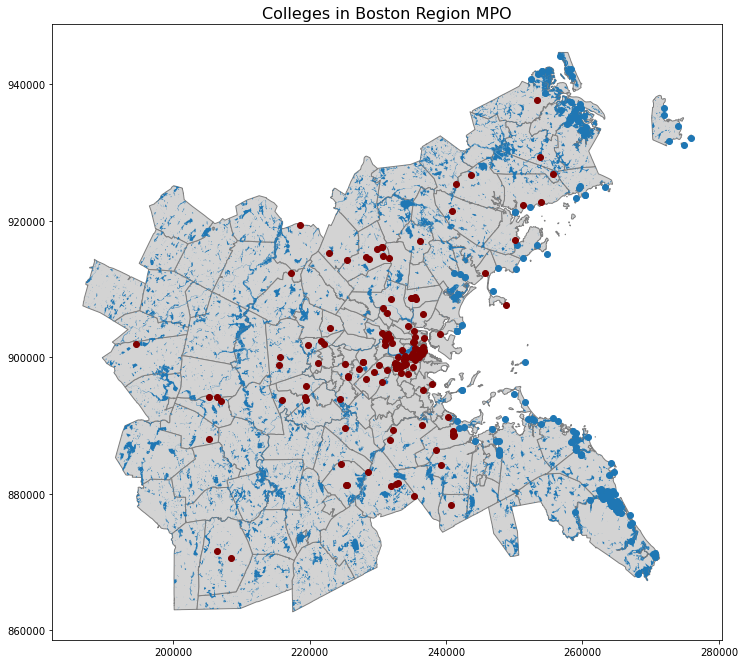

In [22]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
boston_colleges.plot(ax=ax, color='maroon')
plt.title('Colleges in Boston Region MPO', fontsize=16)
plt.show()

In [23]:
college_list = list(colleges.COLLEGE.unique())
college_list

['Cape Cod Electrical School',
 'Cape Cod Community College',
 'Rob Roy Academy',
 'Diman Regional Technical Institute Division of Continuing Education',
 'Bristol Community College',
 'Massachusetts Maritime Academy',
 'Upper Cape Cod Regional Vocational Technical School Practical Nursing Program',
 'Motoring Technical Training Institute',
 'Massasoit Community College',
 'Spa Tech Institute',
 'Wheaton College',
 'Bridgewater State University',
 'Southeastern Technical Institute',
 'Nichols College',
 'Stonehill College',
 'Bay Path University',
 'Ailano School of Cosmetology',
 'Dean College',
 'Baystate Medical Center Midwifery Education Program',
 'Bay Path Adult Evening School',
 'Westfield State University',
 'Branford Hall Career Institute',
 'College of Our Lady of the Elms',
 'DiGrigoli School of Cosmetology',
 'Monarch School of Cosmetology',
 "Mafy's Nails Academy",
 'Jolie Hair and Beauty Academy',
 'Brockton Hospital School of Nursing',
 'Tri County Regional Vocational Te

In [24]:
colleges_select = colleges.loc[colleges.COLLEGE.isin(['Tufts University', 'Boston University'])]
colleges_select

,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,NCES_ID,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
59,Tufts University,School of Veterinary Medicine,200 Westboro Road,North Grafton,01536,None,GRAFTON,(508) 839-7920,http://vet.tufts.edu/,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (185391.454 888431.841)
136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,164988,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)
164,Tufts University,Boston Campus,145 Harrison Avenue,Boston,02111,None,BOSTON,(617) 636-7000,http://medicine.tufts.edu/,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (236057.132 900054.525)


In [25]:
tufts_bu = colleges_select.iloc[[1, 2]].reset_index()
tufts_bu

,index,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,...,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
0,136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
1,163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,...,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)


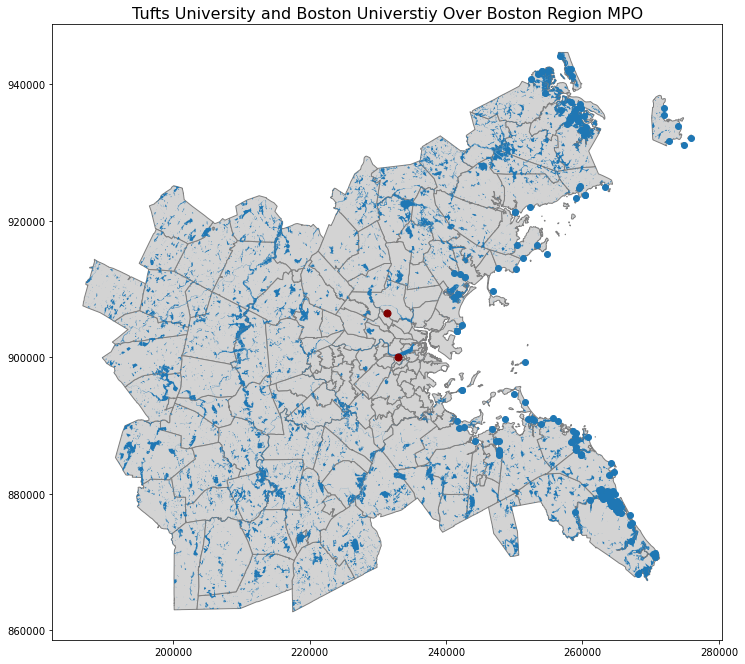

In [30]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Tufts University and Boston Universtiy Over Boston Region MPO', fontsize=16)
plt.show()

## Mass Transit Routes and Stops

In [33]:
mbta_bus = gpd.read_file('./data/MBTA_Bus_Routes_and_Stops/MBTA_Bus_Routes_and_Stops.shp')
print(mbta_bus.crs)
mbta_bus.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   7810 non-null   int64   
 1   STOP_ID    7810 non-null   int64   
 2   STOP_NAME  7810 non-null   object  
 3   TOWN       7810 non-null   object  
 4   TOWN_ID    7810 non-null   int64   
 5   geometry   7810 non-null   geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 366.2+ KB


In [36]:
mbta_bus = mbta_bus.to_crs('epsg:6491')
bos_bus = gpd.clip(mbta_bus, boston_zcta)
bos_bus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7710 entries, 0 to 7809
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   7710 non-null   int64   
 1   STOP_ID    7710 non-null   int64   
 2   STOP_NAME  7710 non-null   object  
 3   TOWN       7710 non-null   object  
 4   TOWN_ID    7710 non-null   int64   
 5   geometry   7710 non-null   geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 421.6+ KB


In [39]:
mbta_rt_arc = gpd.read_file('./data/mbta_rapid_transit/MBTA_ARC.shp')
print(mbta_rt_arc.crs)
mbta_rt_arc.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       138 non-null    object  
 1   ROUTE      138 non-null    object  
 2   GRADE      138 non-null    int64   
 3   SHAPE_LEN  138 non-null    float64 
 4   geometry   138 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 5.5+ KB


In [40]:
mbta_rt_arc = mbta_rt_arc.to_crs('epsg:6491')
bos_rt_arc = gpd.clip(mbta_rt_arc, boston_zcta)
bos_rt_arc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       138 non-null    object  
 1   ROUTE      138 non-null    object  
 2   GRADE      138 non-null    int64   
 3   SHAPE_LEN  138 non-null    float64 
 4   geometry   138 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 6.5+ KB


In [41]:
mbta_rt_node = gpd.read_file('./data/mbta_rapid_transit/MBTA_NODE.shp')
print(mbta_rt_node.crs)
mbta_rt_node.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   166 non-null    object  
 1   LINE      166 non-null    object  
 2   TERMINUS  166 non-null    object  
 3   ROUTE     166 non-null    object  
 4   geometry  166 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 6.6+ KB


In [42]:
mbta_rt_node = mbta_rt_node.to_crs('epsg:6491')
bos_rt_node = gpd.clip(mbta_rt_node, boston_zcta)
bos_rt_node.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   166 non-null    object  
 1   LINE      166 non-null    object  
 2   TERMINUS  166 non-null    object  
 3   ROUTE     166 non-null    object  
 4   geometry  166 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 7.8+ KB


In [43]:
ma_train_route = gpd.read_file('./data/trains/TRAINS_RTE_TRAIN.shp')
print(ma_train_route.crs)
ma_train_route.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   COMM_LINE  19 non-null     object  
 1   COMMRAIL   19 non-null     object  
 2   SHAPE_LEN  19 non-null     float64 
 3   geometry   19 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 736.0+ bytes


In [44]:
ma_train_route = ma_train_route.to_crs('epsg:6491')
bos_train_route = gpd.clip(ma_train_route, boston_zcta)
bos_train_route.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13 entries, 5 to 18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   COMM_LINE  13 non-null     object  
 1   COMMRAIL   13 non-null     object  
 2   SHAPE_LEN  13 non-null     float64 
 3   geometry   13 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 520.0+ bytes


In [45]:
ma_train_node = gpd.read_file('./data/trains/TRAINS_NODE.shp')
print(ma_train_node.crs)
ma_train_node.info()

epsg:26986
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION     387 non-null    object  
 1   C_RAILSTAT  260 non-null    object  
 2   AMTRAK      41 non-null     object  
 3   MAP_STA     234 non-null    object  
 4   LINE_BRNCH  274 non-null    object  
 5   STATE       387 non-null    object  
 6   geometry    387 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 21.3+ KB


In [46]:
ma_train_node = ma_train_node.to_crs('epsg:6491')
bos_train_node = gpd.clip(ma_train_node, boston_zcta)
bos_train_node.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 201 entries, 8 to 386
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION     201 non-null    object  
 1   C_RAILSTAT  192 non-null    object  
 2   AMTRAK      29 non-null     object  
 3   MAP_STA     109 non-null    object  
 4   LINE_BRNCH  198 non-null    object  
 5   STATE       201 non-null    object  
 6   geometry    201 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 12.6+ KB


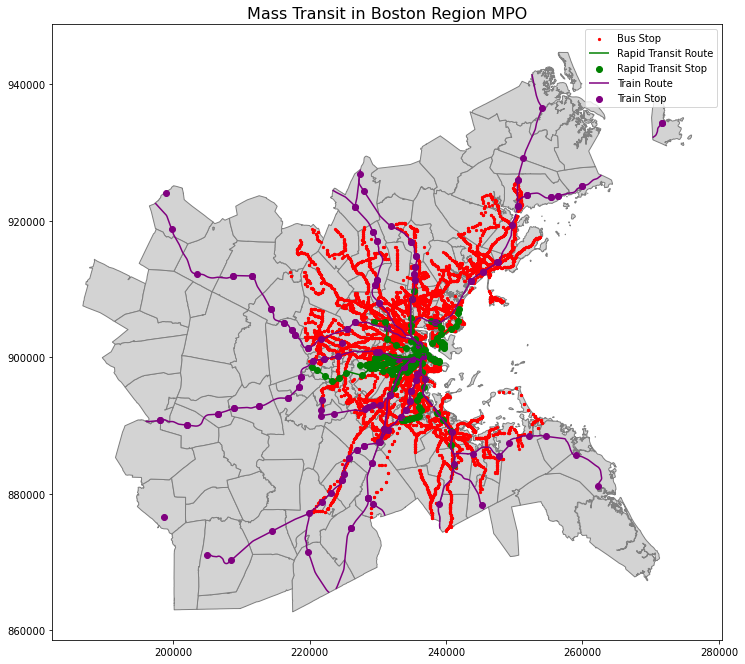

In [52]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
bos_bus.plot(ax=ax, color='red', markersize=5, label='Bus Stop')
bos_rt_arc.plot(ax=ax, color='green', markersize=10, label='Rapid Transit Route')
bos_rt_node.plot(ax=ax, color='green', label='Rapid Transit Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
bos_train_node.plot(ax=ax, color='purple', label='Train Stop')
plt.title('Mass Transit in Boston Region MPO', fontsize=16)
plt.legend()
plt.show()

## Distance to Necessities/Amenities
Amenities are defined as food/groceries, healthcare institutions (acute care, urgent care, hospitals, etc.), safety (firestations)

## Bike Facilities